In [1]:
import os
from shutil import copyfile

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import cv2
from PIL import Image

## Load spreadsheet data into memory:

In [2]:
raw_data = pd.read_csv('av data.csv', header=None)
raw_data[34] = (raw_data[34] + raw_data[12] - raw_data[14] - 1).astype(np.int32)
raw_data[35] = (raw_data[35] + raw_data[10] - raw_data[14] - 1).astype(np.int32)

In [3]:
raw_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,ED001_L,19 Mar 2018,5,BC20CFF8-E570-49FE-8168-B3E8BE271CD7,FDE2EE27-7D3E-48EE-911C-62BE9003616C,fundus camera,1,1.0,L,OD,...,969.6,NaN,NaN,D78BBB0A-2057-42BF-B655-FCD850AD658C,C89DE2F3-5367-4881-9AEF-13DF6766CEE4,1,803,995,0.0,NaN
1,ED001_L,20 Apr 2018,4,BE64C7B9-5842-4680-A926-AD5273C8CC42,42917C3A-9897-4B23-B4A8-5BAB60556253,fundus camera,1,1.0,L,OD,...,969.6,NaN,NaN,B6EB9E8C-355E-420D-B2C3-1A4B6133BAA9,D43703F7-A26B-46E6-9FFF-CA475547D714,1,803,995,0.0,NaN


In [4]:
pixel_data = raw_data[[0, 18, 34, 35, 36]]
pixel_data.columns = ["VIName", "VesselTypeName", "PointX", "PointY", "PointWidth"]
pixel_data.head()

,VIName,VesselTypeName,PointX,PointY,PointWidth
0,ED001_L,Artery,803,995,0.0
1,ED001_L,Artery,803,995,0.0
2,ED001_L,Artery,799,995,2.8
3,ED001_L,Artery,799,995,2.8
4,ED001_L,Artery,795,995,2.0


## Shrink the size of the original images:

In [5]:
original_path = 'images (full)/'
img_path = 'images/'

In [6]:
img_height, img_width, channel = 2048, 3072, 3
shrink_ratio = 0.3

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
for img_name in os.listdir(original_path):
    if img_name.find('.bmp') != -1:
        image = Image.open(original_path + img_name).convert('RGB')
        image = image.resize((int(img_width*shrink_ratio), int(img_height*shrink_ratio)), Image.LANCZOS)
        image.save(img_path + img_name.split('.')[0] + ".tif", compression='tiff_lzw')

## Generate ground truth images:

In [7]:
ground_truth_path = 'ground_truths/'

In [8]:
if not os.path.exists(ground_truth_path):
    os.makedirs(ground_truth_path)

img_height, img_width, channel = 2048, 3072, 3
img, prev_name = None, None

amplifier = 1.5

for index, row in pixel_data.iterrows():
    img_name = row['VIName']
    if img_name != prev_name:
        if img is not None:
            img_artery, img_vein = img[:,:,0], img[:,:,2]
            mask = (img_artery > 0) & (img_vein > 0)
            img[mask] = 0
            mask = (img_artery == 0) & (img_vein == 0)
            img[mask] = np.array([0, 255, 0])
            
            image = Image.fromarray(img, 'RGB')
            image = image.resize((int(img_width*shrink_ratio), int(img_height*shrink_ratio)), Image.NEAREST)
            image.save(ground_truth_path + prev_name + "_labels.tif", compression='tiff_lzw')
        img = np.zeros((img_height, img_width, channel), dtype=np.uint8)
        prev_name = img_name
    
    label = row['VesselTypeName']
    x, y, width = row['PointX'], row['PointY'], int(round(row['PointWidth'] * amplifier))
    
    if label == 'Artery':
        img[y, x, 0] = 255
        for i in range(-width, width+1):
            for j in range(-width, width+1):
                img[y+i, x+j, 0] = 255
        
    elif label == 'Vein':
        img[y, x, 2] = 255
        for i in range(-width, width+1):
            for j in range(-width, width+1):
                img[y+i, x+j, 2] = 255

                
img_artery, img_vein = img[:,:,0], img[:,:,2]
mask = (img_artery > 0) & (img_vein > 0)
img[mask] = 0
mask = (img_artery == 0) & (img_vein == 0)
img[mask] = np.array([0, 255, 0])

image = Image.fromarray(img, 'RGB')
image = image.resize((int(img_width*shrink_ratio), int(img_height*shrink_ratio)), Image.NEAREST)
image.save(ground_truth_path + prev_name + "_labels.tif", compression='tiff_lzw')

## Overlay image and ground truth to check pixel alignments:

In [9]:
image = np.array(Image.open(img_path + img_name + '.tif').convert('RGB'))
ground_truth = np.array(Image.open(ground_truth_path + img_name + '_labels.tif').convert('RGB'))
gt_background = ground_truth[:,:,1]
mask = gt_background > 0
ground_truth[mask] = 0

In [10]:
overlay = image + ground_truth
overlay[overlay < ground_truth] = 255

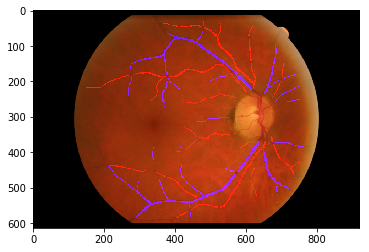

In [11]:
plt.imshow(overlay)
image = Image.fromarray(overlay, 'RGB')
image.save(img_name + "_overlay.tif")

## Generate masks for images:

In [12]:
mask_path = 'masks/'

In [13]:
if not os.path.exists(mask_path):
    os.makedirs(mask_path)

for img_name in os.listdir(img_path):
    img = np.array(Image.open(img_path + img_name).convert('RGB'))
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gray[img_gray > 1] = 255
    image = Image.fromarray(img_gray, 'L')
    image = image.resize((int(img_width*shrink_ratio), int(img_height*shrink_ratio)), Image.NEAREST)
    image.save(mask_path + img_name.split('.')[0] + "_mask.tif", compression='tiff_lzw')

## Split the data into training and test set:

In [14]:
dataset = 'DATASET/'
training, test = 'training/', 'test/'
images, labels, masks = 'images/', 'labels/', 'masks/'

if not os.path.exists(dataset):
    os.makedirs(dataset)

if not os.path.exists(dataset + training):
    os.makedirs(dataset + training)
    
if not os.path.exists(dataset + test):
    os.makedirs(dataset + test)
    
if not os.path.exists(dataset + training + images):
    os.makedirs(dataset + training + images)
    
if not os.path.exists(dataset + training + labels):
    os.makedirs(dataset + training + labels)
    
if not os.path.exists(dataset + training + masks):
    os.makedirs(dataset + training + masks)
    
if not os.path.exists(dataset + test + images):
    os.makedirs(dataset + test + images)
    
if not os.path.exists(dataset + test + labels):
    os.makedirs(dataset + test + labels)
    
if not os.path.exists(dataset + test + masks):
    os.makedirs(dataset + test + masks)

In [15]:
image_data = os.listdir(img_path)
#split_ratio = int(len(image_data) * 0.9)
split = 162
training_images, test_images = image_data[:split], image_data[split:]

for img_name in training_images:
    copyfile(img_path + img_name, dataset + training + images + img_name)
    img_prefix = img_name.split('.')[0]
    label_name = img_prefix + '_labels.tif'
    copyfile(ground_truth_path + label_name, dataset + training + labels + label_name)
    mask_name = img_prefix + '_mask.tif'
    copyfile(mask_path + mask_name, dataset + training + masks + mask_name)
        
for img_name in test_images:
    copyfile(img_path + img_name, dataset + test + images + img_name)
    img_prefix = img_name.split('.')[0]
    label_name = img_prefix + '_labels.tif'
    copyfile(ground_truth_path + label_name, dataset + test + labels + label_name)
    mask_name = img_prefix + '_mask.tif'
    copyfile(mask_path + mask_name, dataset + test + masks + mask_name)